In [1]:
from sklearn.model_selection import StratifiedKFold,train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [2]:
data_1=pd.read_csv("/kaggle/input/bankpromotion/bank-additional-full.csv",sep=";")
data_2=pd.read_csv("/kaggle/input/bankpromotion/bank-additional.csv",sep=";")
data=pd.concat([data_1,data_2],axis=0)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Text(0.5, 1.0, 'Variable Correlation')

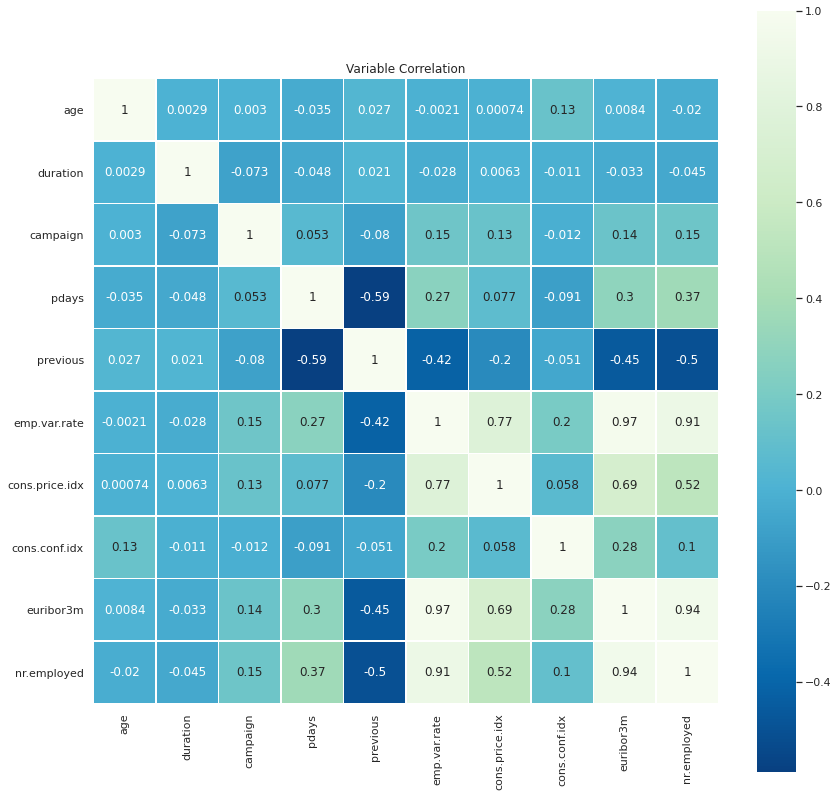

In [3]:
#Correlation Plot
plt.figure(figsize=(14,14))
sns.set(font_scale=1)
sns.heatmap(data.corr(),cmap='GnBu_r',annot=True, square = True ,linewidths=.5);
plt.title('Variable Correlation')

In [4]:
#To avoid mulicorinality drop the higly correltaed column
data = data.drop(["emp.var.rate","nr.employed"],axis=1)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,93.994,-36.4,4.857,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,93.994,-36.4,4.857,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,93.994,-36.4,4.857,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,93.994,-36.4,4.857,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,93.994,-36.4,4.857,no


In [5]:
#label encoding

jobDummies = pd.get_dummies(data['job'], prefix = 'job')
maritalDummies = pd.get_dummies(data['marital'], prefix = 'marital')
educationDummies = pd.get_dummies(data['education'], prefix = 'education')
defaultDummies = pd.get_dummies(data['default'], prefix = 'default')
housingDummies = pd.get_dummies(data['housing'], prefix = 'housing')
loanDummies = pd.get_dummies(data['loan'], prefix = 'loan')
contactDummies = pd.get_dummies(data['contact'], prefix = 'contact')
poutcomeDummies = pd.get_dummies(data['poutcome'], prefix = 'poutcome')
data['month']=data['month'].astype('category')
data['day_of_week']=data['day_of_week'].astype('category')
data['y']=data['y'].astype('category')

# Assigning numerical values and storing in another column
data['month'] = data['month'].cat.codes
data['day_of_week'] = data['day_of_week'].cat.codes
data['y'] = data['y'].cat.codes

data['y'].dtype

dtype('int8')

In [6]:
data["age"]=data["age"].astype("int")
data["duration"]=data["duration"].astype("int")
data["pdays"]=data["pdays"].astype("int")
data["previous"]=data["previous"].astype("int")
data["campaign"]=data["campaign"].astype("int")
data_int=data.select_dtypes(include=['int','float64','bool'])
#data_int
bank_df=pd.concat([data_int,jobDummies,maritalDummies,educationDummies,defaultDummies,housingDummies,loanDummies
                  ,contactDummies,poutcomeDummies,data['month'],data['day_of_week'],data['y']],axis=1)
bank_df.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,job_admin.,job_blue-collar,...,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,month,day_of_week,y
0,56,261,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
1,57,149,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
2,37,226,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
3,40,151,1,999,0,93.994,-36.4,4.857,1,0,...,0,0,0,1,0,1,0,6,1,0
4,56,307,1,999,0,93.994,-36.4,4.857,0,0,...,0,1,0,1,0,1,0,6,1,0


49


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:3

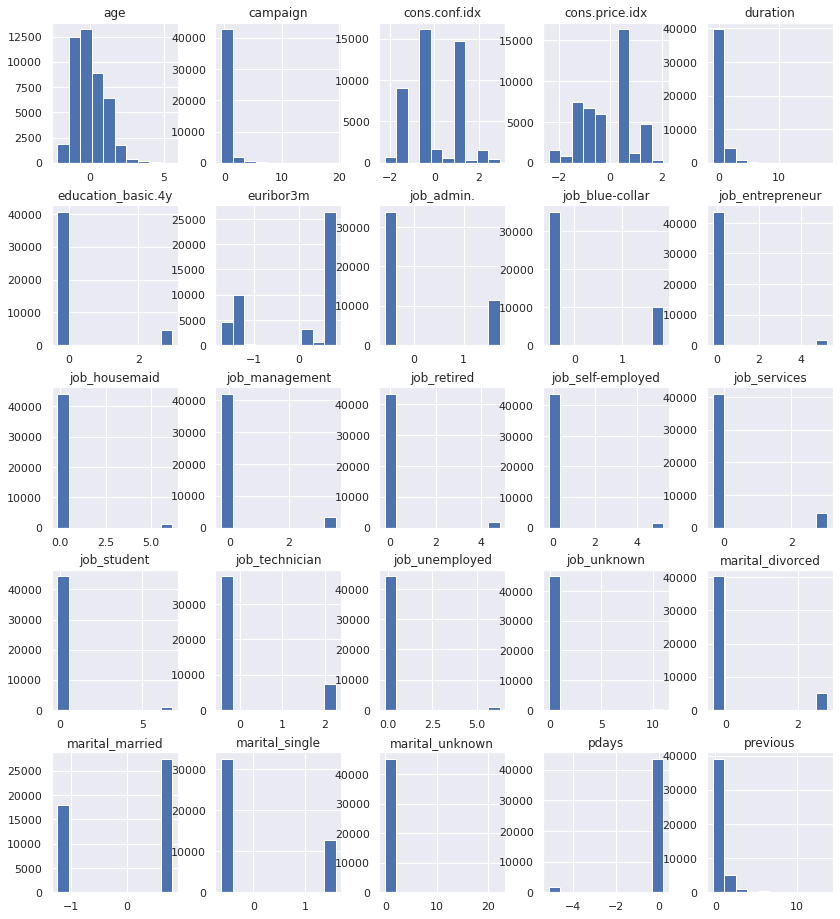

In [7]:
#checking variable distribution
print(len(bank_df.columns))
df_test = bank_df.iloc[:,0:25]
for index in range(25):
    df_test.iloc[:,index] = (df_test.iloc[:,index]-df_test.iloc[:,index].mean()) / df_test.iloc[:,index].std();
df_test.hist(figsize= (14,16));

In [8]:
#Predictors count
bank_df.groupby('y').size()

y
0    40216
1     5091
dtype: int64

In [9]:
#Total features after one-hot-encoding
features = bank_df.columns
len(features)

49

In [10]:
#Variables and Output
y=np.array(bank_df["y"])
X=np.array(bank_df.iloc[:,0:48])

In [11]:
#Partition of Dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

k_range= range(1,26)
scores={}
scores_list=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    scores[k]=metrics.accuracy_score(y_test,y_pred)
    scores_list.append(scores[k])

Text(0, 0.5, 'Testing Accuracy')

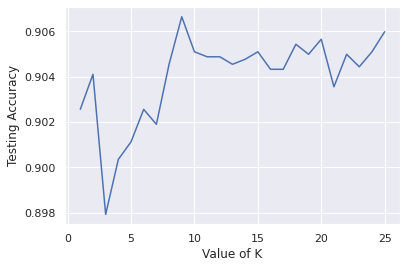

In [13]:
#plot relationship between K and the testing accuracy
plt.plot(k_range,scores_list)
plt.xlabel('Value of K')
plt.ylabel('Testing Accuracy')

In [19]:
print(scores_list)

[0.9025601412491724, 0.9041050540719487, 0.8979254027808431, 0.9003531229309203, 0.9011255793423085, 0.9025601412491724, 0.9018980357536968, 0.9045464577355992, 0.9066431251379387, 0.9050982123151622, 0.904877510483337, 0.904877510483337, 0.9045464577355992, 0.9047671595674244, 0.9050982123151622, 0.904325755903774, 0.904325755903774, 0.9054292650629, 0.9049878613992496, 0.9056499668947252, 0.9035532994923858, 0.9049878613992496, 0.9044361068196866, 0.9050982123151622, 0.905981019642463]


In [29]:
knn=KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [30]:
y_pred=knn.predict(X_test)

In [31]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.906643
Precision: 0.635071
Recall: 0.395280
F1 score: 0.487273


In [32]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[7814  231]
 [ 615  402]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8045
           1       0.64      0.40      0.49      1017

    accuracy                           0.91      9062
   macro avg       0.78      0.68      0.72      9062
weighted avg       0.89      0.91      0.90      9062



In [42]:
knn=KNeighborsClassifier(n_neighbors=9,weights='distance')
#‘distance’ : weight points by the inverse of their distance. 
#in this case, closer neighbors of a query point will have a greater 
#influence than neighbors which are further away.
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

In [43]:
y_pred=knn.predict(X_test)

In [44]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.918120
Precision: 0.701318
Recall: 0.470993
F1 score: 0.563529


In [45]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[7841  204]
 [ 538  479]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      8045
           1       0.70      0.47      0.56      1017

    accuracy                           0.92      9062
   macro avg       0.82      0.72      0.76      9062
weighted avg       0.91      0.92      0.91      9062



In [23]:


scores = []
n=5
i=0
mean_auc=0
seed=7
accuracy_test=0
accuracy_train=0
#cv = KFold(n_splits=n, random_state=42, shuffle=True)

cv = StratifiedKFold(n_splits=n, shuffle=True, random_state=seed)
knn=KNeighborsClassifier(n_neighbors=5)


In [24]:

for train_index, test_index in cv.split(X_train,y_train):
    X_train_cv, X_test_cv= X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    
    #Fit Model
    knn.fit(X_train,y_train)

    #predict train
    preds_train = knn.predict(X_train_cv)

    #predict test
    preds_test = knn.predict(X_test_cv)
    
    i+=1
    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_test_cv, preds_test)
    roc_auc = metrics.auc(fpr, tpr)
    print ("AUC (fold "+str(i)+"/"+str(n)+"): "+str(roc_auc))
    mean_auc += roc_auc
    
    print("Accuracy Validation Fold "+str(i)+" : "+str(metrics.accuracy_score(y_test_cv,preds_test)*100))
    accuracy_test+=metrics.accuracy_score(y_test_cv,preds_test)*100
    print("Accuracy Train Fold "+str(i)+" : "+str(metrics.accuracy_score(y_train_cv,preds_train)*100))
    accuracy_train+=metrics.accuracy_score(y_train_cv,preds_train)*100
    print(" ")
    
print ("Mean AUC: "+str(mean_auc/n) )
print ("Mean Validation Accuracy: "+str(accuracy_test/n))
print ("Mean Train Accuracy: "+str(accuracy_train/n))

AUC (fold 1/5): 0.7658382158382158
Accuracy Validation Fold 1 : 93.00593185266933
Accuracy Train Fold 1 : 93.04041936818872
 
AUC (fold 2/5): 0.7528462672420863
Accuracy Validation Fold 2 : 92.74382673472203
Accuracy Train Fold 2 : 93.10594564767554
 
AUC (fold 3/5): 0.7719259837023786
Accuracy Validation Fold 3 : 92.99213684646158
Accuracy Train Fold 3 : 93.04386811974067
 
AUC (fold 4/5): 0.7661877754490618
Accuracy Validation Fold 4 : 93.01972685887708
Accuracy Train Fold 4 : 93.03697061663678
 
AUC (fold 5/5): 0.785508828672829
Accuracy Validation Fold 5 : 93.40598703269416
Accuracy Train Fold 5 : 92.9404055731825
 
Mean AUC: 0.7684614141809143
Mean Validation Accuracy: 93.03352186508485
Mean Train Accuracy: 93.03352186508484


In [25]:
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[7739  306]
 [ 590  427]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      8045
           1       0.58      0.42      0.49      1017

    accuracy                           0.90      9062
   macro avg       0.76      0.69      0.72      9062
weighted avg       0.89      0.90      0.89      9062



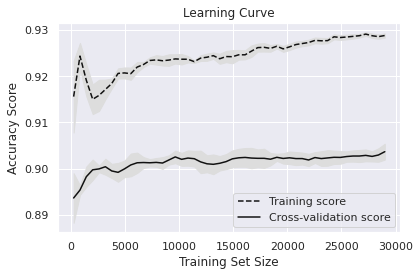

In [26]:
##from sklearn.model_selection import kfold
#from sklearn.svm import SVC
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(knn, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=cv,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()